In [1]:
from basketball_reference_web_scraper import client
# from basketball_reference_web_scraper.data import Team

games = client.season_schedule(2022)

games

[{'start_time': datetime.datetime(2021, 10, 19, 23, 30, tzinfo=<UTC>),
  'away_team': <Team.BROOKLYN_NETS: 'BROOKLYN NETS'>,
  'home_team': <Team.MILWAUKEE_BUCKS: 'MILWAUKEE BUCKS'>,
  'away_team_score': 104,
  'home_team_score': 127},
 {'start_time': datetime.datetime(2021, 10, 20, 2, 0, tzinfo=<UTC>),
  'away_team': <Team.GOLDEN_STATE_WARRIORS: 'GOLDEN STATE WARRIORS'>,
  'home_team': <Team.LOS_ANGELES_LAKERS: 'LOS ANGELES LAKERS'>,
  'away_team_score': 121,
  'home_team_score': 114},
 {'start_time': datetime.datetime(2021, 10, 20, 23, 0, tzinfo=<UTC>),
  'away_team': <Team.INDIANA_PACERS: 'INDIANA PACERS'>,
  'home_team': <Team.CHARLOTTE_HORNETS: 'CHARLOTTE HORNETS'>,
  'away_team_score': 122,
  'home_team_score': 123},
 {'start_time': datetime.datetime(2021, 10, 20, 23, 0, tzinfo=<UTC>),
  'away_team': <Team.CHICAGO_BULLS: 'CHICAGO BULLS'>,
  'home_team': <Team.DETROIT_PISTONS: 'DETROIT PISTONS'>,
  'away_team_score': 94,
  'home_team_score': 88},
 {'start_time': datetime.datetime(

In [2]:
import os
import time
import pytz
from builtins import round
from basketball_reference_web_scraper.data import OutputType

i = 0
for game in games:
    gameTime = game["start_time"].astimezone(pytz.timezone('US/Eastern'))
    if os.path.exists("games/" + str(round(gameTime.timestamp())) + "_" + game["home_team"].name + ".csv"):
        print("Game: " + str(round(gameTime.timestamp())) + "_" + game["home_team"].name + ".csv" + " already exists")
        continue
    
    try:
        print("Downloading: " + str(round(gameTime.timestamp())) + "_" + game["home_team"].name + ".csv")
        client.play_by_play(home_team=game["home_team"], year=gameTime.year, month=gameTime.month, day=gameTime.day, output_type=OutputType.CSV, output_file_path="games/" + str(round(gameTime.timestamp())) + "_" + game["home_team"].name + ".csv")
        i += 1

        time.sleep(2.0)
    except:
        print("Error: " + str(round(gameTime.timestamp())) + "_" + game["home_team"].name + ".csv")
        break

print("Downloaded " + str(i) + " games")

Game: 1634686200_MILWAUKEE_BUCKS.csv already exists
Game: 1634695200_LOS_ANGELES_LAKERS.csv already exists
Game: 1634770800_CHARLOTTE_HORNETS.csv already exists
Game: 1634770800_DETROIT_PISTONS.csv already exists
Game: 1634772600_NEW_YORK_KNICKS.csv already exists
Game: 1634772600_TORONTO_RAPTORS.csv already exists
Game: 1634774400_MEMPHIS_GRIZZLIES.csv already exists
Game: 1634774400_MINNESOTA_TIMBERWOLVES.csv already exists
Game: 1634774400_NEW_ORLEANS_PELICANS.csv already exists
Game: 1634776200_SAN_ANTONIO_SPURS.csv already exists
Game: 1634778000_UTAH_JAZZ.csv already exists
Game: 1634781600_PORTLAND_TRAIL_BLAZERS.csv already exists
Game: 1634781600_PHOENIX_SUNS.csv already exists
Game: 1634859000_ATLANTA_HAWKS.csv already exists
Game: 1634860800_MIAMI_HEAT.csv already exists
Game: 1634868000_GOLDEN_STATE_WARRIORS.csv already exists
Game: 1634943600_ORLANDO_MAGIC.csv already exists
Game: 1634943600_WASHINGTON_WIZARDS.csv already exists
Game: 1634943600_CLEVELAND_CAVALIERS.csv alre

In [3]:
import os
import glob
import pandas as pd

all_filenames = [i for i in glob.glob('games/[0-9]*.{}'.format('csv'))]

combined_csv = pd.DataFrame()

#combine all files in the list
for f in all_filenames:
    df = pd.read_csv(f)
    df.insert(0, 'game_id', f.split('\\')[1].split('.')[0])
    combined_csv = pd.concat([combined_csv, df])

#export to csv
combined_csv.to_csv("combined_games.csv", index=False, encoding='utf-8')

In [4]:
#import findspark
#findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("NBA_Data").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

df = spark.read.format("csv").option("header", "true").load("combined_games.csv")

df.createOrReplaceTempView("games")

dfFGs = spark.sql("SELECT *, regexp_extract(description, '(2|3)-pt') as shot_type, regexp_extract(description, '(makes|misses)') as shot_result, regexp_extract(description, '(.*) (?:makes|misses)') as player FROM games where regexp_extract(description, '(2|3)-pt') in (2, 3)")

dfFTs = spark.sql("SELECT *, regexp_extract(description, '(free throw [0-9] of [0-9])') as shot_type, regexp_extract(description, '(makes|misses)') as shot_result, regexp_extract(description, '(.*) (?:makes|misses)') as player FROM games where description like '%free throw%'")

# dfFGs.show(10)
# dfFTs.show(10)

dfAll = dfFGs.union(dfFTs)

dfAll.createOrReplaceTempView("all_shots")

dfAll.show(10)

+--------------------+------+-----------+---------------------------+---------------+-------------+---------------+----------+----------+--------------------+---------+-----------+----------------+
|             game_id|period|period_type|remaining_seconds_in_period|  relevant_team|    away_team|      home_team|away_score|home_score|         description|shot_type|shot_result|          player|
+--------------------+------+-----------+---------------------------+---------------+-------------+---------------+----------+----------+--------------------+---------+-----------+----------------+
|1634686200_MILWAU...|     1|    QUARTER|                      702.0|MILWAUKEE BUCKS|BROOKLYN NETS|MILWAUKEE BUCKS|         0|         0|G. Allen misses 3...|        3|     misses|        G. Allen|
|1634686200_MILWAU...|     1|    QUARTER|                      673.0|MILWAUKEE BUCKS|BROOKLYN NETS|MILWAUKEE BUCKS|         0|         0|G. Antetokounmpo ...|        3|     misses|G. Antetokounmpo|
|163468620

In [5]:
# Shot breakdown for first 3 minutes
df3x2_detail = spark.sql("""select game_id, home_team, away_team, shot_type, shot_result, count(*) as total_shots
from all_shots 
where period_type = 'QUARTER' and period = 1 and cast(remaining_seconds_in_period as int) >= 540
group by game_id, home_team, away_team, shot_type, shot_result
order by game_id, shot_type""")

df3x2_detail.createOrReplaceTempView("3x2_detail")

df3x2_detail.show()

+--------------------+------------------+--------------------+-----------------+-----------+-----------+
|             game_id|         home_team|           away_team|        shot_type|shot_result|total_shots|
+--------------------+------------------+--------------------+-----------------+-----------+-----------+
|1634686200_MILWAU...|   MILWAUKEE BUCKS|       BROOKLYN NETS|                2|     misses|          6|
|1634686200_MILWAU...|   MILWAUKEE BUCKS|       BROOKLYN NETS|                2|      makes|          4|
|1634686200_MILWAU...|   MILWAUKEE BUCKS|       BROOKLYN NETS|                3|     misses|          3|
|1634686200_MILWAU...|   MILWAUKEE BUCKS|       BROOKLYN NETS|                3|      makes|          1|
|1634686200_MILWAU...|   MILWAUKEE BUCKS|       BROOKLYN NETS|free throw 1 of 2|     misses|          1|
|1634686200_MILWAU...|   MILWAUKEE BUCKS|       BROOKLYN NETS|free throw 2 of 2|     misses|          1|
|1634695200_LOS_AN...|LOS ANGELES LAKERS|GOLDEN STATE W

In [6]:
from pyspark.sql.functions import col, round, row_number, lit
from pyspark.sql.window import Window

df3x2_makes = spark.sql("""select game_id, home_team, away_team, sum(total_shots) as 3pt_makes
from 3x2_detail 
where shot_result = 'makes' and shot_type = 3
group by game_id, home_team, away_team, shot_type, shot_result
order by game_id""")

df3x2_makes.createOrReplaceTempView("3x2_makes")

df3x2_zeros = spark.sql("""select distinct game_id, home_team, away_team, 0 as 3pt_makes
from all_shots where game_id not in (select distinct game_id from 3x2_makes)""")

df3x2_results = df3x2_makes.union(df3x2_zeros).withColumn("game_number", row_number().over(Window.partitionBy(lit(0)).orderBy(col("game_id"))))

df3x2_results.createOrReplaceTempView("3x2_results")

df3x2_results.show()

+--------------------+--------------------+--------------------+---------+-----------+
|             game_id|           home_team|           away_team|3pt_makes|game_number|
+--------------------+--------------------+--------------------+---------+-----------+
|1634686200_MILWAU...|     MILWAUKEE BUCKS|       BROOKLYN NETS|        1|          1|
|1634695200_LOS_AN...|  LOS ANGELES LAKERS|GOLDEN STATE WARR...|        1|          2|
|1634770800_CHARLO...|   CHARLOTTE HORNETS|      INDIANA PACERS|        1|          3|
|1634770800_DETROI...|     DETROIT PISTONS|       CHICAGO BULLS|        0|          4|
|1634772600_NEW_YO...|     NEW YORK KNICKS|      BOSTON CELTICS|        3|          5|
|1634772600_TORONT...|     TORONTO RAPTORS|  WASHINGTON WIZARDS|        2|          6|
|1634774400_MEMPHI...|   MEMPHIS GRIZZLIES| CLEVELAND CAVALIERS|        1|          7|
|1634774400_MINNES...|MINNESOTA TIMBERW...|     HOUSTON ROCKETS|        2|          8|
|1634774400_NEW_OR...|NEW ORLEANS PELICANS|

+---------+-----+
|3pt_makes|count|
+---------+-----+
|        0|  134|
|        1|  232|
|        2|  209|
|        3|  105|
|        4|   36|
|        5|    6|
|        6|    3|
+---------+-----+

359 / 725 = 49.52%


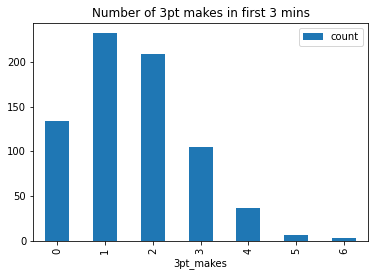

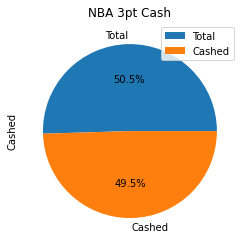

In [7]:
import pandas
from builtins import round

df3x2Breakdown = spark.sql("""select 3pt_makes, count(3pt_makes) as count
from 3x2_results 
group by 3pt_makes
order by 3pt_makes""")

df3x2Breakdown.show()

df3x2Breakdown.toPandas().plot(kind='bar', x='3pt_makes', y='count', title='Number of 3pt makes in first 3 mins')



total_games = spark.sql("""select count(distinct game_id) as total_games from all_shots""").first().total_games

cashed = spark.sql("""select count(3pt_makes) as cash from 3x2_results
where 3pt_makes >= 2""").first().cash

dfTotals = pandas.DataFrame({"Cashed": [total_games - cashed, cashed]}, index=["Total", "Cashed"])

dfTotals.plot(kind='pie', y='Cashed', autopct='%1.1f%%', title='NBA 3pt Cash')

print("{} / {} = {}%".format(cashed, total_games, round((cashed / total_games) * 100, 2)))

In [8]:
import pandas

df3x2TeamBreakdown = spark.sql("""select game_number, home_team, away_team, 3pt_makes, count(3pt_makes) as count
from 3x2_results 
group by game_number, home_team, away_team, 3pt_makes
order by home_team, 3pt_makes""")

df3x2TeamBreakdown.createOrReplaceTempView("3x2_team_breakdown")

df3x2TeamBreakdown.show()

df3x2TeamBreakdownMakes = spark.sql("""select game_number, home_team, away_team, 3pt_makes, sum(count) as count
from 3x2_team_breakdown 
where 3pt_makes >= 2
group by game_number, home_team, away_team, 3pt_makes""")

df3x2TeamBreakdownMakes.createOrReplaceTempView("3x2_team_breakdown_makes")

df3x2TeamBreakdownMakes.show()

df3x2TeamBreakdownMisses = spark.sql("""select game_number, home_team, away_team, 3pt_makes, sum(count) as count
from 3x2_team_breakdown 
where 3pt_makes < 2
group by game_number, home_team, away_team, 3pt_makes""")

df3x2TeamBreakdownMisses.createOrReplaceTempView("3x2_team_breakdown_misses")

df3x2TeamBreakdownMisses.show()

+-----------+-------------+--------------------+---------+-----+
|game_number|    home_team|           away_team|3pt_makes|count|
+-----------+-------------+--------------------+---------+-----+
|        652|ATLANTA HAWKS|     MILWAUKEE BUCKS|        0|    1|
|        242|ATLANTA HAWKS|   CHARLOTTE HORNETS|        0|    1|
|        335|ATLANTA HAWKS|  PHILADELPHIA 76ERS|        0|    1|
|        612|ATLANTA HAWKS|          MIAMI HEAT|        0|    1|
|        255|ATLANTA HAWKS|OKLAHOMA CITY THU...|        1|    1|
|        634|ATLANTA HAWKS|     NEW YORK KNICKS|        1|    1|
|        384|ATLANTA HAWKS|       BROOKLYN NETS|        2|    1|
|         97|ATLANTA HAWKS|  WASHINGTON WIZARDS|        2|    1|
|        215|ATLANTA HAWKS|      BOSTON CELTICS|        2|    1|
|        407|ATLANTA HAWKS|     HOUSTON ROCKETS|        2|    1|
|         14|ATLANTA HAWKS|    DALLAS MAVERICKS|        2|    1|
|        293|ATLANTA HAWKS|     NEW YORK KNICKS|        2|    1|
|        679|ATLANTA HAWK

In [9]:
import pandas
from pyspark.sql.functions import col, round, row_number, lit
from pyspark.sql.window import Window

df3x2TeamMakes = spark.sql("""select home_team as team, sum(count) as count
from 3x2_team_breakdown_makes
group by home_team""").union(
    spark.sql("""select away_team as team, sum(count) as count
    from 3x2_team_breakdown_makes
    group by away_team""")
)

df3x2TeamMakes.createOrReplaceTempView("3x2_team_makes")

df3x2TeamMakesFinal = spark.sql("""select team, sum(count) as make_count
from 3x2_team_makes
group by team
order by make_count desc""")

# df3x2TeamMakesFinal.show()

df3x2TeamMisses = spark.sql("""select home_team as team, sum(count) as count
from 3x2_team_breakdown_misses
group by home_team""").union(
    spark.sql("""select away_team as team, sum(count) as count
    from 3x2_team_breakdown_misses
    group by away_team""")
)

df3x2TeamMisses.createOrReplaceTempView("3x2_team_misses")

df3x2TeamMissesFinal = spark.sql("""select team, sum(count) as miss_count
from 3x2_team_misses
group by team
order by miss_count desc""")

# df3x2TeamMissesFinal.show()

dfTeamTotalGames = spark.sql("""select team, sum(count) as total_games
from (
    select team, count
    from 3x2_team_makes
    union all
    select team, count
    from 3x2_team_misses
) a
group by team
order by total_games desc""")

# dfTeamTotalGames.show()

dfFullTeamBreakdown = df3x2TeamMissesFinal.join(df3x2TeamMakesFinal, on='team').join(dfTeamTotalGames, on='team').withColumn("make_pct", round((col("make_count") / col("total_games")) * 100, 2)) \
    .select('team', 'make_count', 'miss_count', 'total_games', 'make_pct').orderBy('make_pct', ascending=False).withColumn("rank", row_number().over(Window.partitionBy(lit(0)).orderBy(col("make_pct").desc()))) \
        .select('rank', 'team', 'make_count', 'miss_count', 'total_games', 'make_pct')
dfFullTeamBreakdown.createOrReplaceTempView("full_team_breakdown")

dfFullTeamBreakdown.show()

+----+--------------------+----------+----------+-----------+--------+
|rank|                team|make_count|miss_count|total_games|make_pct|
+----+--------------------+----------+----------+-----------+--------+
|   1|     NEW YORK KNICKS|        35|        14|         49|   71.43|
|   2|     HOUSTON ROCKETS|        33|        15|         48|   68.75|
|   3|       ATLANTA HAWKS|        29|        18|         47|    61.7|
|   4|       CHICAGO BULLS|        27|        20|         47|   57.45|
|   5|      DENVER NUGGETS|        27|        20|         47|   57.45|
|   6|       BROOKLYN NETS|        27|        21|         48|   56.25|
|   7|MINNESOTA TIMBERW...|        27|        21|         48|   56.25|
|   8|PORTLAND TRAIL BL...|        26|        22|         48|   54.17|
|   9|OKLAHOMA CITY THU...|        25|        22|         47|   53.19|
|  10|           UTAH JAZZ|        26|        23|         49|   53.06|
|  11|GOLDEN STATE WARR...|        26|        23|         49|   53.06|
|  12|

In [10]:
import pandas
from pyspark.sql.functions import col, round, row_number, lit
from pyspark.sql.window import Window

game_number_last_15 = spark.sql("""select max(game_number) as max_game_number
from 3x2_team_breakdown""").first().max_game_number - 85*3

df3x2TeamBreakdownMakesLast15 = df3x2TeamBreakdownMakes.filter(col("game_number") >= game_number_last_15)
df3x2TeamBreakdownMissesLast15 = df3x2TeamBreakdownMisses.filter(col("game_number") >= game_number_last_15)
df3x2TeamBreakdownMakesLast15.createOrReplaceTempView("3x2_team_breakdown_makes_last_15")
df3x2TeamBreakdownMissesLast15.createOrReplaceTempView("3x2_team_breakdown_misses_last_15")

df3x2TeamMakesLast15 = spark.sql("""select home_team as team, sum(count) as count
from 3x2_team_breakdown_makes_last_15
group by home_team""").union(
    spark.sql("""select away_team as team, sum(count) as count
    from 3x2_team_breakdown_makes_last_15
    group by away_team""")
)

df3x2TeamMakesLast15.createOrReplaceTempView("3x2_team_makes_last_15")

df3x2TeamMakesFinalLast15 = spark.sql("""select team, sum(count) as make_count
from 3x2_team_makes_last_15
group by team
order by make_count desc""")

# df3x2TeamMakesFinal.show()

df3x2TeamMissesLast15 = spark.sql("""select home_team as team, sum(count) as count
from 3x2_team_breakdown_misses_last_15
group by home_team""").union(
    spark.sql("""select away_team as team, sum(count) as count
    from 3x2_team_breakdown_misses_last_15
    group by away_team""")
)

df3x2TeamMissesLast15.createOrReplaceTempView("3x2_team_misses_last_15")

df3x2TeamMissesFinalLast15 = spark.sql("""select team, sum(count) as miss_count
from 3x2_team_misses_last_15
group by team
order by miss_count desc""")

# df3x2TeamMissesFinal.show()

dfTeamTotalGamesLast15 = spark.sql("""select team, sum(count) as total_games
from (
    select team, count
    from 3x2_team_makes_last_15
    union all
    select team, count
    from 3x2_team_misses_last_15
) a
group by team
order by total_games desc""")

# dfTeamTotalGames.show()

dfFullTeamBreakdownLast15 = df3x2TeamMissesFinalLast15.join(df3x2TeamMakesFinalLast15, on='team').join(dfTeamTotalGamesLast15, on='team').withColumn("make_pct", round((col("make_count") / col("total_games")) * 100, 2)) \
    .select('team', 'make_count', 'miss_count', 'total_games', 'make_pct').orderBy('make_pct', ascending=False).withColumn("rank", row_number().over(Window.partitionBy(lit(0)).orderBy(col("make_pct").desc()))) \
        .select('rank', 'team', 'make_count', 'miss_count', 'total_games', 'make_pct')
dfFullTeamBreakdownLast15.createOrReplaceTempView("full_team_breakdown_last_15")

dfFullTeamBreakdownLast15.show()

+----+--------------------+----------+----------+-----------+--------+
|rank|                team|make_count|miss_count|total_games|make_pct|
+----+--------------------+----------+----------+-----------+--------+
|   1|     HOUSTON ROCKETS|        14|         1|         15|   93.33|
|   2|     TORONTO RAPTORS|        12|         5|         17|   70.59|
|   3|          MIAMI HEAT|        11|         5|         16|   68.75|
|   4|     NEW YORK KNICKS|        12|         6|         18|   66.67|
|   5|    SACRAMENTO KINGS|        11|         6|         17|   64.71|
|   6|      DENVER NUGGETS|        11|         6|         17|   64.71|
|   7|MINNESOTA TIMBERW...|        11|         6|         17|   64.71|
|   8|       BROOKLYN NETS|        11|         7|         18|   61.11|
|   9|PORTLAND TRAIL BL...|         9|         7|         16|   56.25|
|  10|      BOSTON CELTICS|         9|         8|         17|   52.94|
|  11|  WASHINGTON WIZARDS|         9|         8|         17|   52.94|
|  12|

In [11]:
import pandas
from pyspark.sql.functions import col, round, row_number, lit
from pyspark.sql.window import Window

game_number_last_5 = spark.sql("""select max(game_number) as max_game_number
from 3x2_team_breakdown""").first().max_game_number - 85

df3x2TeamBreakdownMakesLast5 = df3x2TeamBreakdownMakes.filter(col("game_number") >= game_number_last_5)
df3x2TeamBreakdownMissesLast5 = df3x2TeamBreakdownMisses.filter(col("game_number") >= game_number_last_5)
df3x2TeamBreakdownMakesLast5.createOrReplaceTempView("3x2_team_breakdown_makes_last_5")
df3x2TeamBreakdownMissesLast5.createOrReplaceTempView("3x2_team_breakdown_misses_last_5")

df3x2TeamMakesLast5 = spark.sql("""select home_team as team, sum(count) as count
from 3x2_team_breakdown_makes_last_5
group by home_team""").union(
    spark.sql("""select away_team as team, sum(count) as count
    from 3x2_team_breakdown_makes_last_5
    group by away_team""")
)

df3x2TeamMakesLast5.createOrReplaceTempView("3x2_team_makes_last_5")

df3x2TeamMakesFinalLast5 = spark.sql("""select team, sum(count) as make_count
from 3x2_team_makes_last_5
group by team
order by make_count desc""")

# df3x2TeamMakesFinal.show()

df3x2TeamMissesLast5 = spark.sql("""select home_team as team, sum(count) as count
from 3x2_team_breakdown_misses_last_5
group by home_team""").union(
    spark.sql("""select away_team as team, sum(count) as count
    from 3x2_team_breakdown_misses_last_5
    group by away_team""")
)

df3x2TeamMissesLast5.createOrReplaceTempView("3x2_team_misses_last_5")

df3x2TeamMissesFinalLast5 = spark.sql("""select team, sum(count) as miss_count
from 3x2_team_misses_last_5
group by team
order by miss_count desc""")

# df3x2TeamMissesFinal.show()

dfTeamTotalGamesLast5 = spark.sql("""select team, sum(count) as total_games
from (
    select team, count
    from 3x2_team_makes_last_5
    union all
    select team, count
    from 3x2_team_misses_last_5
) a
group by team
order by total_games desc""")

# dfTeamTotalGames.show()

dfFullTeamBreakdownLast5 = df3x2TeamMissesFinalLast5.join(df3x2TeamMakesFinalLast5, on='team').join(dfTeamTotalGamesLast5, on='team').withColumn("make_pct", round((col("make_count") / col("total_games")) * 100, 2)) \
    .select('team', 'make_count', 'miss_count', 'total_games', 'make_pct').orderBy('make_pct', ascending=False).withColumn("rank", row_number().over(Window.partitionBy(lit(0)).orderBy(col("make_pct").desc()))) \
        .select('rank', 'team', 'make_count', 'miss_count', 'total_games', 'make_pct')
dfFullTeamBreakdownLast5.createOrReplaceTempView("full_team_breakdown_last_5")

dfFullTeamBreakdownLast5.show()

+----+--------------------+----------+----------+-----------+--------+
|rank|                team|make_count|miss_count|total_games|make_pct|
+----+--------------------+----------+----------+-----------+--------+
|   1|          MIAMI HEAT|         4|         1|          5|    80.0|
|   2|    SACRAMENTO KINGS|         4|         1|          5|    80.0|
|   3|       BROOKLYN NETS|         4|         2|          6|   66.67|
|   4|     NEW YORK KNICKS|         4|         2|          6|   66.67|
|   5|MINNESOTA TIMBERW...|         4|         2|          6|   66.67|
|   6|      BOSTON CELTICS|         3|         2|          5|    60.0|
|   7|       ATLANTA HAWKS|         3|         2|          5|    60.0|
|   8|     MILWAUKEE BUCKS|         3|         2|          5|    60.0|
|   9|           UTAH JAZZ|         4|         3|          7|   57.14|
|  10|GOLDEN STATE WARR...|         4|         3|          7|   57.14|
|  11|      DENVER NUGGETS|         4|         3|          7|   57.14|
|  12|

In [12]:
import pandas

dfFullTeamBreakdownWithRecent = spark.sql("""select ftb.*, concat(ftb5.make_count, '-', ftb5.miss_count) as make_miss_recent_5, concat(ftb15.make_count, '-', ftb15.miss_count) as make_miss_recent_15,
case when (ftb5.make_count / (ftb5.make_count + ftb5.miss_count)) * 100 > ftb.make_pct then 'up' else 'down' end as trend_recent_5
from full_team_breakdown ftb
inner join full_team_breakdown_last_15 ftb15 on ftb.team = ftb15.team
inner join full_team_breakdown_last_5 ftb5 on ftb.team = ftb5.team
order by ftb.rank
""")

dfFullTeamBreakdownWithRecent.cache()

dfFullTeamBreakdownWithRecent.createOrReplaceTempView("full_team_breakdown_with_recent")

dfFullTeamBreakdownWithRecent.show()

+----+--------------------+----------+----------+-----------+--------+------------------+-------------------+--------------+
|rank|                team|make_count|miss_count|total_games|make_pct|make_miss_recent_5|make_miss_recent_15|trend_recent_5|
+----+--------------------+----------+----------+-----------+--------+------------------+-------------------+--------------+
|   1|     NEW YORK KNICKS|        35|        14|         49|   71.43|               4-2|               12-6|          down|
|   3|       ATLANTA HAWKS|        29|        18|         47|    61.7|               3-2|                8-9|          down|
|   4|       CHICAGO BULLS|        27|        20|         47|   57.45|               2-4|                9-9|          down|
|   5|      DENVER NUGGETS|        27|        20|         47|   57.45|               4-3|               11-6|          down|
|   6|       BROOKLYN NETS|        27|        21|         48|   56.25|               4-2|               11-7|            up|


In [13]:
import pandas
from builtins import round
from basketball_reference_web_scraper import client
import pytz
from datetime import datetime

games = client.season_schedule(2022)
todaysGames = []

for game in games:
    gameTime = game["start_time"].astimezone(pytz.timezone('US/Eastern'))
    if gameTime.date() == datetime.today().date():
        todaysGames.append(game)
    elif gameTime.date() > datetime.today().date():
        break

print("Found {} games for today".format(len(todaysGames)))

for game in todaysGames:
    dfMatchup = spark.sql("""select * from full_team_breakdown_with_recent where team in ('{}', '{}')""".format(game["home_team"].value, game["away_team"].value))

    dfMatchup.show()

    dfMatchup = dfMatchup.collect()

    try:
        team1_pct = dfMatchup[0].make_pct
    except:
        team1_pct = 0
    
    try:
        team2_pct = dfMatchup[1].make_pct
    except:
        team2_pct = 0

    total_pct = (team1_pct + team2_pct) / 2

    dec_odds = 1 / (total_pct / 100)

    #For decimal odds of 2.00 or greater, the formula is as follows: (decimal odds - 1) * 100 = American odds.
    #For decimal odds between 1.01 and 1.99, the formula is as follows: -100 / (decimal odds - 1) = American odds.
    american_odds = 0
    if dec_odds >= 2:
        american_odds = (dec_odds - 1) * 100
    elif dec_odds < 2:
        american_odds = -100 / (dec_odds - 1)

    print("Percentage: {}%, American odds: {:+}".format(round(total_pct, 2), round(american_odds)))
    print("")
    print("")

Found 11 games for today
+----+---------------+----------+----------+-----------+--------+------------------+-------------------+--------------+
|rank|           team|make_count|miss_count|total_games|make_pct|make_miss_recent_5|make_miss_recent_15|trend_recent_5|
+----+---------------+----------+----------+-----------+--------+------------------+-------------------+--------------+
|  24|DETROIT PISTONS|        20|        27|         47|   42.55|               2-4|                8-9|          down|
+----+---------------+----------+----------+-----------+--------+------------------+-------------------+--------------+

Percentage: 21.27%, American odds: +370


+----+--------------+----------+----------+-----------+--------+------------------+-------------------+--------------+
|rank|          team|make_count|miss_count|total_games|make_pct|make_miss_recent_5|make_miss_recent_15|trend_recent_5|
+----+--------------+----------+----------+-----------+--------+------------------+-----------

h1. NBA First Bucket

In [14]:
import pandas
from pyspark.sql.functions import round

dfFirstBuckets = spark.sql("""select game_id, max(cast(remaining_seconds_in_period as float)) as remaining_seconds_in_period
from all_shots
where shot_result = 'makes' and period = 1
group by game_id
order by game_id""")

dfFirstBuckets.createOrReplaceTempView("first_buckets")

dfFirstBucketsWithPlayers = spark.sql("""select distinct fb.game_id, as.relevant_team, fb.remaining_seconds_in_period, as.player
from first_buckets fb
inner join all_shots as on fb.game_id = as.game_id and fb.remaining_seconds_in_period = as.remaining_seconds_in_period
where as.period = 1
order by game_id""")

dfFirstBucketsWithPlayers.createOrReplaceTempView("first_buckets_with_players")

dfAllShotsBeforeMake = spark.sql("""select distinct as.game_id, as.relevant_team, as.remaining_seconds_in_period, as.player, as.shot_result
from all_shots as
inner join first_buckets fb on as.game_id = fb.game_id
where as.period = 1 and cast(as.remaining_seconds_in_period as float) >= cast(fb.remaining_seconds_in_period as float)
order by game_id, cast(as.remaining_seconds_in_period as float) desc""")

dfAllShotsBeforeMake.createOrReplaceTempView("all_shots_before_make")

dfAllShotsBeforeMakeBreakdown = spark.sql("""select player, relevant_team, count(player) as shot_count
from all_shots_before_make 
group by player, relevant_team
order by shot_count desc""")

dfAllShotsBeforeMakeBreakdown.createOrReplaceTempView("all_shots_before_make_breakdown")

#dfAllShotsBeforeMakeBreakdown.show(10)

dfFirstBucketsBreakdown = spark.sql("""select player, relevant_team, count(player) as make_count
from first_buckets_with_players 
group by player, relevant_team
order by make_count desc""")

dfFirstBucketsBreakdown.createOrReplaceTempView("first_buckets_breakdown")

#dfFirstBucketsBreakdown.show(10)

dfPlayerGames = spark.sql("""select player, relevant_team, count(distinct game_id) as games
from all_shots
group by player, relevant_team
order by relevant_team, games desc""")

dfTotalGames = spark.sql("""select relevant_team, count(distinct game_id) as team_games
from all_shots
group by relevant_team
order by relevant_team""")

dfPlayerTotalGames = dfPlayerGames.join(dfTotalGames, on='relevant_team').selectExpr('player', 'relevant_team', 'games', 'team_games', 'round((games / team_games) * 100, 2) as pct_games')

dfPlayerTotalGames.createOrReplaceTempView("player_total_games")

dfAllShotsWithFirstBuckets = spark.sql("""select as.player, as.relevant_team, as.shot_count, coalesce(fb.make_count, 0) as make_count, ptg.games as player_games, ptg.team_games, round(as.shot_count / ptg.games, 2) as avg_shots_per_game, round(coalesce(fb.make_count, 0) / ptg.games, 2) as avg_makes_per_game
from all_shots_before_make_breakdown as
inner join player_total_games ptg on as.player = ptg.player and as.relevant_team = ptg.relevant_team
left outer join first_buckets_breakdown fb on as.player = fb.player and as.relevant_team = fb.relevant_team
order by make_count desc""")

dfAllShotsWithFirstBuckets.createOrReplaceTempView("all_shots_with_first_buckets")

dfAllShotsWithFirstBuckets.show(10)


+------------+--------------------+----------+----------+------------+----------+------------------+------------------+
|      player|       relevant_team|shot_count|make_count|player_games|team_games|avg_shots_per_game|avg_makes_per_game|
+------------+--------------------+----------+----------+------------+----------+------------------+------------------+
|   J. Nurkić|PORTLAND TRAIL BL...|        28|        12|          45|        48|              0.62|              0.27|
|K. Porziņģis|    DALLAS MAVERICKS|        20|        10|          33|        49|              0.61|               0.3|
|   D. Booker|        PHOENIX SUNS|        19|        10|          40|        47|              0.48|              0.25|
|   W. Barton|      DENVER NUGGETS|        11|         9|          41|        47|              0.27|              0.22|
|  J. Crowder|        PHOENIX SUNS|        14|         9|          39|        47|              0.36|              0.23|
|     C. Wood|     HOUSTON ROCKETS|     

In [15]:
import pandas
from builtins import round
from basketball_reference_web_scraper import client
import pytz
from datetime import datetime

games = client.season_schedule(2022)
todaysGames = []

for game in games:
    gameTime = game["start_time"].astimezone(pytz.timezone('US/Eastern'))
    if gameTime.date() == datetime.today().date():
        todaysGames.append(game)
    elif gameTime.date() > datetime.today().date():
        break

print("Found {} games for today".format(len(todaysGames)))

lstTeams = []

for game in todaysGames:
    lstTeams.append(game["home_team"].value)
    lstTeams.append(game["away_team"].value)

dfTodaysFirstBucketData = spark.sql("""select * from all_shots_with_first_buckets where relevant_team in ('{}')""".format("','".join(lstTeams)))

dfTodaysFirstBucketData.show()

Found 11 games for today
+-----------+--------------------+----------+----------+------------+----------+------------------+------------------+
|     player|       relevant_team|shot_count|make_count|player_games|team_games|avg_shots_per_game|avg_makes_per_game|
+-----------+--------------------+----------+----------+------------+----------+------------------+------------------+
|  J. Nurkić|PORTLAND TRAIL BL...|        28|        12|          45|        48|              0.62|              0.27|
|  D. Booker|        PHOENIX SUNS|        19|        10|          40|        47|              0.48|              0.25|
|  W. Barton|      DENVER NUGGETS|        11|         9|          41|        47|              0.27|              0.22|
| J. Crowder|        PHOENIX SUNS|        14|         9|          39|        47|              0.36|              0.23|
|    C. Wood|     HOUSTON ROCKETS|        15|         9|          45|        48|              0.33|               0.2|
|  J. Randle|     NEW Y